# Initial Conditions for TC Flow

Want to have incompressible, broad-band noise ICs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dedalus.public as de

In [2]:
nr = 32
nz = 64
ntheta = 128
Gamma = 3
eta = 0.875
mu = 0
Re1 = 1000

dealias=3/2

In [3]:
#derived parameters
R1 = eta/(1. - eta)
R2 = 1./(1-eta)
Omega1 = 1/R1
Omega2 = mu*Omega1
nu = R1 * Omega1/Re1
midpoint = R1 + (R2-R1) / 2
Lz = Gamma

Ltheta = 2*np.pi

r_in = R1

A0 = 1e-3

In [4]:
#domain
z_basis = de.Fourier(  'z', nz, interval=[0., Lz], dealias=dealias)
theta_basis = de.Fourier('theta', ntheta, interval=[0., Ltheta], dealias=dealias)
r_basis = de.Chebyshev('r', nr, interval=[R1, R2], dealias=dealias)

bases = [z_basis, theta_basis, r_basis]
# ~ bases = t_bases + r_basis
domain = de.Domain(bases, grid_dtype=np.float64)  

In [5]:
u = domain.new_field()
v = domain.new_field()
w = domain.new_field()

In [6]:
z,theta, r = domain.grids(scales=domain.dealias)

In [21]:
# Random perturbations to v in (r, z)
gshape = domain.dist.grid_layout.global_shape(scales=domain.dealias)
slices = domain.dist.grid_layout.slices(scales=domain.dealias)
rand = np.random.RandomState(seed=42)

#logger.info("Using incompressible noise initial conditions in (u, v, w) with amplitude A0 = {}.".format(A0))
Ar = domain.new_field()
Atheta = domain.new_field()
Az = domain.new_field()
for A in [Ar, Atheta, Az]:
    A.set_scales(domain.dealias, keep_data=False)
    A['g'] = rand.standard_normal(gshape)[slices]*np.sin(np.pi*(r - r_in))
    #A.set_scales(0.5,keep_data=True)
    #A['c']
    #A['g']
    #A.set_scales(domain.dealias,keep_data=True)

for vel in [u, v, w]:
    vel.set_scales(domain.dealias, keep_data=False)
u['g'] = A0 * (Az.differentiate('theta')['g']/r - Atheta.differentiate('z')['g'])
v['g'] = A0 * (Ar.differentiate('z')['g'] - Az.differentiate('r')['g'])
w['g'] = A0 * (Atheta['g'] + r*Atheta.differentiate('r')['g'] - Ar.differentiate('theta')['g'])/r
# kz = 2*np.pi/Lz
# v['g'] = A0 * np.sin(np.pi*(r-r_in)) * np.sin(kz*z)
# w['g'] = A0 * np.sin(np.pi*(r-r_in)) * np.sin(m1*theta)


In [22]:
np.allclose(Ar['g'],Atheta['g'])

False

In [23]:
up = (u['c']*u['c'].conj()).real
vp = (v['c']*v['c'].conj()).real
wp = (w['c']*w['c'].conj()).real
Arp = (Ar['c']*Ar['c'].conj()).real
Atp = (Atheta['c']*Atheta['c'].conj()).real
Azp = (Az['c']*Az['c'].conj()).real

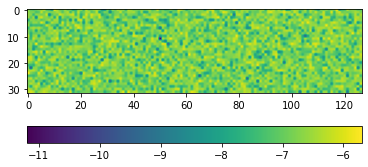

In [24]:
plt.imshow(np.log10(Azp[:,:,1]))
plt.colorbar(orientation='horizontal')

In [25]:
def div(Ar,At,Az, r):
    divu = Ar.differentiate('r')['g'] + Ar['g']/r + At.differentiate('theta')['g']/r + Az.differentiate('z')['g']
    
    return divu

In [26]:
divu = div(u, v, w, r)

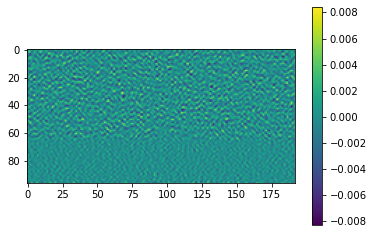

In [29]:
plt.imshow(divu[:,:,15])
plt.colorbar()